In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

In [4]:
from func_utils_pt import acl_spectrum, ESS
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [5]:
network = Net

In [6]:
x_dim = 2
mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network).to(device)

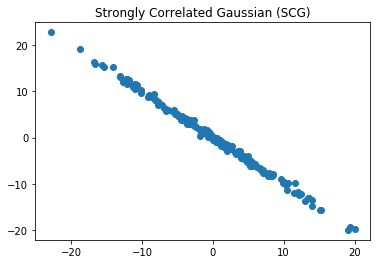

In [7]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [8]:
n_steps = 5000
n_samples = 200

In [9]:
optim = Adam(itertools.chain(dynamics.XNet.parameters(), dynamics.VNet.parameters()))
scheduler = StepLR(optim, step_size=1000, gamma=0.96)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

for t in tqdm(range(n_steps)):
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32).to(device)
    else:
        x = output[0].detach().to(device)
        
    z = torch.randn_like(x).to(device)
    
    x.requires_grad_(False)
    z.requires_grad_(False)
    
    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4).to(device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4).to(device)
    scale = torch.tensor(0.1).to(device)

    loss = criterion(v1, v2)
    loss.backward()
    
    optim.step()
    
    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<20:36,  4.04it/s]

Step: 0 / 5000, Loss: 2.19e+02, Acceptance sample: 0.54, LR: 0.00100


  2%|▏         | 101/5000 [00:24<20:00,  4.08it/s]

Step: 100 / 5000, Loss: 9.47e+01, Acceptance sample: 0.35, LR: 0.00100


  4%|▍         | 201/5000 [00:49<19:26,  4.12it/s]

Step: 200 / 5000, Loss: 1.07e+02, Acceptance sample: 0.33, LR: 0.00100


  6%|▌         | 301/5000 [01:13<19:19,  4.05it/s]

Step: 300 / 5000, Loss: 3.36e+00, Acceptance sample: 0.32, LR: 0.00100


  8%|▊         | 401/5000 [01:38<18:25,  4.16it/s]

Step: 400 / 5000, Loss: -3.65e+01, Acceptance sample: 0.33, LR: 0.00100


 10%|█         | 501/5000 [02:02<18:36,  4.03it/s]

Step: 500 / 5000, Loss: -9.12e+01, Acceptance sample: 0.29, LR: 0.00100


 12%|█▏        | 601/5000 [02:27<17:57,  4.08it/s]

Step: 600 / 5000, Loss: 7.82e-01, Acceptance sample: 0.30, LR: 0.00100


 14%|█▍        | 701/5000 [02:51<17:31,  4.09it/s]

Step: 700 / 5000, Loss: -1.06e+02, Acceptance sample: 0.33, LR: 0.00100


 16%|█▌        | 801/5000 [03:16<17:31,  3.99it/s]

Step: 800 / 5000, Loss: -5.18e+01, Acceptance sample: 0.29, LR: 0.00100


 18%|█▊        | 901/5000 [03:41<16:38,  4.11it/s]

Step: 900 / 5000, Loss: -3.97e+01, Acceptance sample: 0.34, LR: 0.00100


 20%|██        | 1001/5000 [04:05<16:23,  4.06it/s]

Step: 1000 / 5000, Loss: -6.90e+01, Acceptance sample: 0.32, LR: 0.00096


 22%|██▏       | 1101/5000 [04:30<15:57,  4.07it/s]

Step: 1100 / 5000, Loss: -1.14e+02, Acceptance sample: 0.37, LR: 0.00096


 24%|██▍       | 1201/5000 [04:55<15:43,  4.03it/s]

Step: 1200 / 5000, Loss: -2.24e+02, Acceptance sample: 0.38, LR: 0.00096


 26%|██▌       | 1301/5000 [05:19<15:07,  4.08it/s]

Step: 1300 / 5000, Loss: -2.82e+02, Acceptance sample: 0.36, LR: 0.00096


 28%|██▊       | 1401/5000 [05:44<14:51,  4.04it/s]

Step: 1400 / 5000, Loss: -2.07e+02, Acceptance sample: 0.42, LR: 0.00096


 30%|███       | 1501/5000 [06:09<14:33,  4.01it/s]

Step: 1500 / 5000, Loss: -3.01e+02, Acceptance sample: 0.40, LR: 0.00096


 32%|███▏      | 1601/5000 [06:33<13:57,  4.06it/s]

Step: 1600 / 5000, Loss: -3.16e+02, Acceptance sample: 0.36, LR: 0.00096


 34%|███▍      | 1701/5000 [06:58<13:32,  4.06it/s]

Step: 1700 / 5000, Loss: -4.76e+02, Acceptance sample: 0.36, LR: 0.00096


 36%|███▌      | 1801/5000 [07:22<13:08,  4.06it/s]

Step: 1800 / 5000, Loss: -4.62e+02, Acceptance sample: 0.41, LR: 0.00096


 38%|███▊      | 1901/5000 [07:47<12:49,  4.03it/s]

Step: 1900 / 5000, Loss: -5.08e+02, Acceptance sample: 0.33, LR: 0.00096


 40%|████      | 2001/5000 [08:12<12:17,  4.07it/s]

Step: 2000 / 5000, Loss: -7.45e+02, Acceptance sample: 0.37, LR: 0.00092


 42%|████▏     | 2101/5000 [08:37<12:04,  4.00it/s]

Step: 2100 / 5000, Loss: -8.20e+02, Acceptance sample: 0.39, LR: 0.00092


 44%|████▍     | 2201/5000 [09:01<11:31,  4.05it/s]

Step: 2200 / 5000, Loss: -1.12e+03, Acceptance sample: 0.33, LR: 0.00092


 46%|████▌     | 2301/5000 [09:26<11:12,  4.01it/s]

Step: 2300 / 5000, Loss: -1.20e+03, Acceptance sample: 0.32, LR: 0.00092


 48%|████▊     | 2401/5000 [09:51<10:50,  4.00it/s]

Step: 2400 / 5000, Loss: -1.36e+03, Acceptance sample: 0.30, LR: 0.00092


 50%|█████     | 2501/5000 [10:16<10:24,  4.00it/s]

Step: 2500 / 5000, Loss: -1.64e+03, Acceptance sample: 0.37, LR: 0.00092


 52%|█████▏    | 2601/5000 [10:41<09:48,  4.07it/s]

Step: 2600 / 5000, Loss: -2.20e+03, Acceptance sample: 0.35, LR: 0.00092


 54%|█████▍    | 2701/5000 [11:05<09:20,  4.10it/s]

Step: 2700 / 5000, Loss: -2.75e+03, Acceptance sample: 0.29, LR: 0.00092


 56%|█████▌    | 2801/5000 [11:30<09:01,  4.06it/s]

Step: 2800 / 5000, Loss: -2.84e+03, Acceptance sample: 0.30, LR: 0.00092


 58%|█████▊    | 2901/5000 [11:54<08:37,  4.05it/s]

Step: 2900 / 5000, Loss: -2.67e+03, Acceptance sample: 0.25, LR: 0.00092


 60%|██████    | 3001/5000 [12:19<08:13,  4.05it/s]

Step: 3000 / 5000, Loss: -3.21e+03, Acceptance sample: 0.28, LR: 0.00088


 62%|██████▏   | 3101/5000 [12:44<07:47,  4.06it/s]

Step: 3100 / 5000, Loss: -2.92e+03, Acceptance sample: 0.27, LR: 0.00088


 64%|██████▍   | 3201/5000 [13:08<07:22,  4.06it/s]

Step: 3200 / 5000, Loss: -2.80e+03, Acceptance sample: 0.26, LR: 0.00088


 66%|██████▌   | 3301/5000 [13:33<06:56,  4.08it/s]

Step: 3300 / 5000, Loss: -3.04e+03, Acceptance sample: 0.30, LR: 0.00088


 68%|██████▊   | 3401/5000 [13:58<06:32,  4.07it/s]

Step: 3400 / 5000, Loss: -2.81e+03, Acceptance sample: 0.26, LR: 0.00088


 70%|███████   | 3501/5000 [14:22<06:00,  4.16it/s]

Step: 3500 / 5000, Loss: -2.89e+03, Acceptance sample: 0.29, LR: 0.00088


 72%|███████▏  | 3601/5000 [14:46<05:44,  4.06it/s]

Step: 3600 / 5000, Loss: -3.26e+03, Acceptance sample: 0.28, LR: 0.00088


 74%|███████▍  | 3701/5000 [15:11<05:21,  4.04it/s]

Step: 3700 / 5000, Loss: -3.36e+03, Acceptance sample: 0.24, LR: 0.00088


 76%|███████▌  | 3801/5000 [15:36<04:56,  4.04it/s]

Step: 3800 / 5000, Loss: -3.09e+03, Acceptance sample: 0.32, LR: 0.00088


 78%|███████▊  | 3901/5000 [16:00<04:30,  4.06it/s]

Step: 3900 / 5000, Loss: -2.71e+03, Acceptance sample: 0.25, LR: 0.00088


 80%|████████  | 4001/5000 [16:25<04:08,  4.03it/s]

Step: 4000 / 5000, Loss: -3.33e+03, Acceptance sample: 0.32, LR: 0.00085


 82%|████████▏ | 4101/5000 [16:50<03:40,  4.08it/s]

Step: 4100 / 5000, Loss: -3.84e+03, Acceptance sample: 0.23, LR: 0.00085


 84%|████████▍ | 4201/5000 [17:15<03:15,  4.08it/s]

Step: 4200 / 5000, Loss: -3.50e+03, Acceptance sample: 0.34, LR: 0.00085


 86%|████████▌ | 4301/5000 [17:39<02:53,  4.04it/s]

Step: 4300 / 5000, Loss: -3.17e+03, Acceptance sample: 0.28, LR: 0.00085


 88%|████████▊ | 4401/5000 [18:04<02:29,  4.02it/s]

Step: 4400 / 5000, Loss: -3.14e+03, Acceptance sample: 0.30, LR: 0.00085


 90%|█████████ | 4501/5000 [18:29<02:01,  4.10it/s]

Step: 4500 / 5000, Loss: -3.24e+03, Acceptance sample: 0.24, LR: 0.00085


 92%|█████████▏| 4601/5000 [18:53<01:37,  4.11it/s]

Step: 4600 / 5000, Loss: -3.31e+03, Acceptance sample: 0.28, LR: 0.00085


 94%|█████████▍| 4701/5000 [19:18<01:13,  4.08it/s]

Step: 4700 / 5000, Loss: -3.56e+03, Acceptance sample: 0.26, LR: 0.00085


 96%|█████████▌| 4801/5000 [19:42<00:49,  4.03it/s]

Step: 4800 / 5000, Loss: -3.45e+03, Acceptance sample: 0.32, LR: 0.00085


 98%|█████████▊| 4901/5000 [20:07<00:24,  4.10it/s]

Step: 4900 / 5000, Loss: -3.59e+03, Acceptance sample: 0.27, LR: 0.00085


100%|██████████| 5000/5000 [20:31<00:00,  4.17it/s]


In [21]:
length_of_chains = 300

In [22]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32).to(device)
final_samples = []

samples_ = samples
for t in tqdm(range(length_of_chains)):
    final_samples.append(samples_.cpu().detach().numpy())
    _, _, _, samples_ = propose(samples_, dynamics, do_mh_step=True)
    samples_ = samples_[0]

100%|██████████| 300/300 [00:22<00:00, 13.64it/s]


In [23]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples)

100%|██████████| 300/300 [00:04<00:00, 60.22it/s]


In [24]:
L2HMC_samples.shape

(300, 200, 2)

In [25]:
HMC_samples_1.shape

(300, 200, 2)

In [26]:
# from func_utils_pt import acl_spectrum, ESS

In [27]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

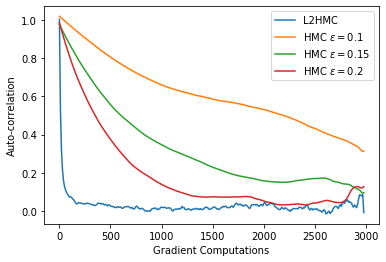

In [28]:
xaxis = 10 * np.arange(length_of_chains - 1)
plt.plot(xaxis, L2HMC, label='L2HMC')
plt.plot(xaxis, HMC1, label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2, label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3, label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

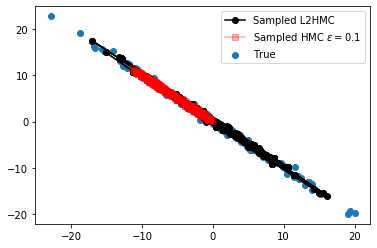

In [29]:
num = 1

plt.scatter(S[:, 0], S[:, 1], label='True')
plt.plot(L2HMC_samples[:, num, 0], L2HMC_samples[:, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_1[:, num, 0], HMC_samples_1[:, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()